In [1]:
# Import dependencies
import os
import glob
import re
import datetime
import conf as cf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set parameters

# Just uncomment if you want to create a new workspace
#version = datetime.datetime.now().strftime('%Y%m%d')
version = "20231002"
workspace = os.path.join(cf.path_data_workspace,version)
os.makedirs(workspace, exist_ok=True)



# Load all inputs


In [3]:
# Create
step1 = "01-join inputs"
step1_ws = os.path.join(workspace,step1)
os.makedirs(step1_ws, exist_ok=True)
file_sorting_save = os.path.join(step1_ws,"01-inputs-full-raw.csv")
file_duplicates = os.path.join(step1_ws,"02-inputs-cleaning.csv")

In [4]:
csv_files = glob.glob(os.path.join(cf.path_data_inputs,"*.csv"))

inputs_df = pd.DataFrame()

# Iterate through each CSV file and read it into a DataFrame, then concatenate it with the combined DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    inputs_df = pd.concat([inputs_df, df], ignore_index=True)

# Add id
inputs_df.insert(0, 'id', range(1, 1 + len(inputs_df)))

# Print the combined DataFrame
print(inputs_df.head())

# Sorting and saving
inputs_df = inputs_df.sort_values(by=["intent","text"])
inputs_df.to_csv(file_sorting_save,encoding=cf.encoding_utf,index=False)

print("Size full",inputs_df.shape)

# Removing duplicates and nan
inputs_df = inputs_df.drop_duplicates()
inputs_df = inputs_df.dropna()
inputs_df.to_csv(file_duplicates,encoding=cf.encoding_utf,index=False)

print("Size without duplicates and nan",inputs_df.shape)

   id             text     intent
0   1  [object Object]  cultivars
1   2             Hola         hi
2   3             Hola         hi
3   4             Hola         hi
4   5             Hola         hi
Size full (3306, 3)
Size without duplicates and nan (3024, 3)


Text(0.5, 1.0, 'Histogram of character lengths in text')

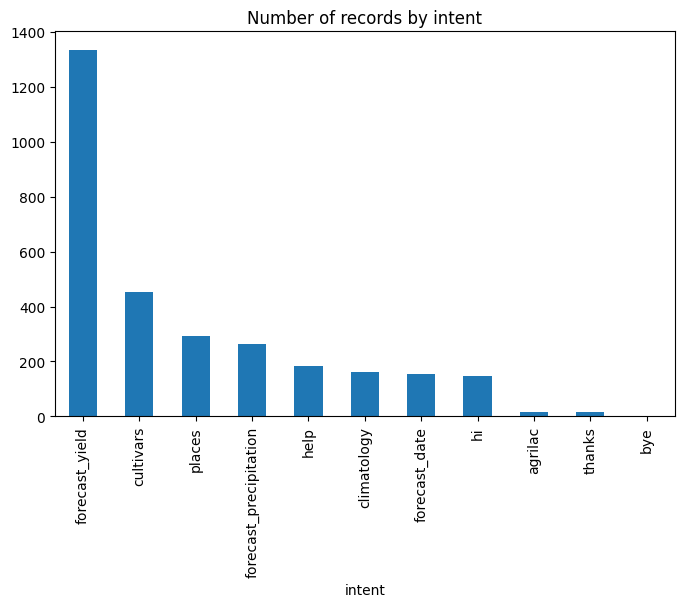

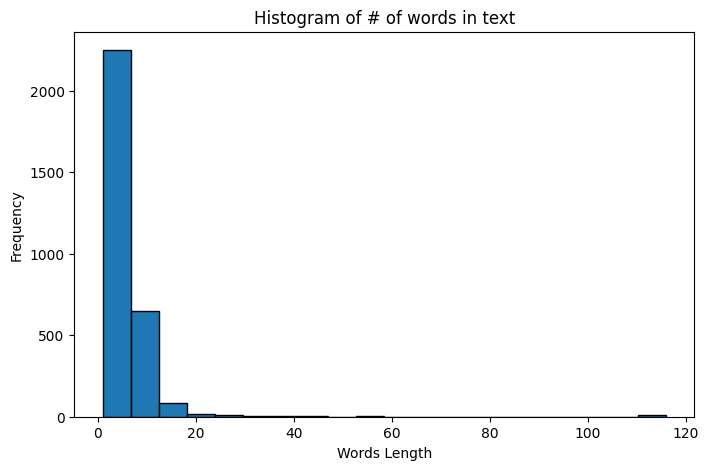

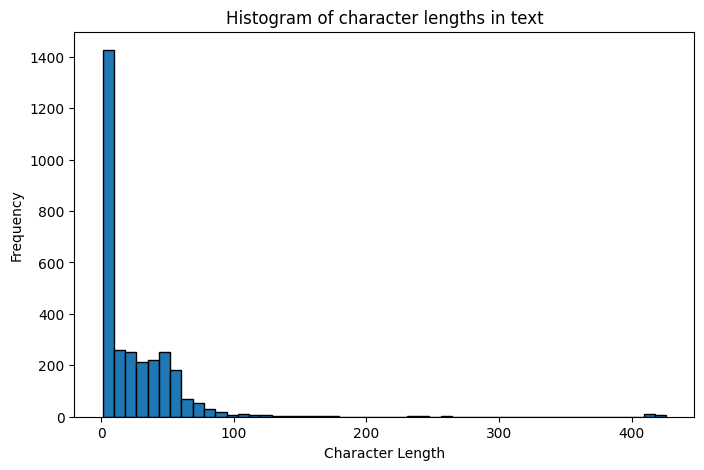

In [5]:
#inputs_df = pd.read_csv(file_duplicates,encoding=cf.encoding_utf)

# Number of records by intent
plt.figure(figsize=(8,5))
ax1 = inputs_df['intent'].value_counts().plot(kind='bar')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Number of records by intent")

# Histogram about length of strings
inputs_df['word_length'] = inputs_df['text'].apply(lambda x: len(str(x).split(' ')))
# Plot a histogram of the word lengths (length of characters)
plt.figure(figsize=(8, 5))
plt.hist(inputs_df['word_length'], bins=20, edgecolor='black')
# Add labels and title
plt.xlabel('Words Length')
plt.ylabel('Frequency')
plt.title('Histogram of # of words in text')

# Histogram about length of strings
inputs_df['character_length'] = inputs_df['text'].apply(lambda x: len(str(x)))
# Plot a histogram of the word lengths (length of characters)
plt.figure(figsize=(8, 5))
plt.hist(inputs_df['character_length'], bins=50, edgecolor='black')
# Add labels and title
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Histogram of character lengths in text')

# Filtering

In [6]:
# Create
step2 = "02-filtering"
step2_ws = os.path.join(workspace,step2)
os.makedirs(step2_ws, exist_ok=True)
file_by_intent = os.path.join(step2_ws,"01-filtered-intent.csv")


In [7]:
#inputs_df = pd.read_csv(file_duplicates,encoding=cf.encoding_utf)

# Identifying intents to work
intents = inputs_df['intent'].unique().tolist()
print(intents)
items_to_remove = ['agrilac', 'thanks', 'bye', 'bye', 'hi', 'help']
intents_focus = [item for item in intents if item not in items_to_remove]
print(intents_focus)

# Filtering intents
intents_df = inputs_df.loc[inputs_df["intent"].isin(intents_focus)]
intents_df.to_csv(file_by_intent,encoding=cf.encoding_utf,index=False)

['agrilac', 'bye', 'climatology', 'cultivars', 'forecast_date', 'forecast_precipitation', 'forecast_yield', 'help', 'hi', 'places', 'thanks']
['climatology', 'cultivars', 'forecast_date', 'forecast_precipitation', 'forecast_yield', 'places']


# Cleaning data

In [8]:
# Create
step3 = "03-cleaning"
step3_ws = os.path.join(workspace,step3)
os.makedirs(step3_ws, exist_ok=True)
file_iso_format = os.path.join(step3_ws,"01-inputs-iso-format.csv")
file_new_text = os.path.join(step3_ws,"02-inputs-new-text.csv")
file_cleaned = os.path.join(step3_ws,"03-inputs-cleaned.csv")
file_cleaned_filtered = os.path.join(step3_ws,"04-inputs-cleaned-filtered.csv")

In [9]:
#intents_df = pd.read_csv(file_by_intent,encoding=cf.encoding_utf)

# Changing the format and removing stranger characters
inputs_reg_ex = intents_df.replace({r'[^\x20-\x7E]': '?'}, regex=True)
inputs_reg_ex.to_csv(file_iso_format,encoding=cf.encoding,index=False)

In [10]:
#intents_df = pd.read_csv(file_by_intent,encoding=cf.encoding_utf)

# Explode records by ?

# Identify records containing "?"
intents_df['new_text'] = intents_df['text']
records_with_question = intents_df['new_text'].str.contains('\?')

# Split records into multiple rows based on the number of "?"
split_df = intents_df[records_with_question].copy()
split_df['new_text'] = split_df['new_text'].str.split('\?')

# Explode the DataFrame to split into multiple rows
split_df = split_df.explode('new_text')

# Combine the original DataFrame and the split DataFrame
new_text_df = pd.concat([intents_df[~records_with_question], split_df], ignore_index=True)
new_text_df['word_length_new_text'] = new_text_df['new_text'].apply(lambda x: len(str(x).split(' ')))
new_text_df['character_length_new_text'] = new_text_df['new_text'].apply(lambda x: len(str(x)))
new_text_df.to_csv(file_new_text,encoding=cf.encoding_utf,index=False)


C:\Users\hsotelo\AppData\Local\Temp\ipykernel_26832\2073936129.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intents_df['new_text'] = intents_df['text']


In [11]:
#new_text_df = pd.read_csv(file_new_text,encoding=cf.encoding_utf)

# Function to remove non-alphanumeric characters
def remove_strange_characters(text):
    # Remove enters
    cleaned_text = text.strip()
    # Define a regex pattern to match characters that are not letters, digits, or spaces
    cleaned_text = ''.join(e for e in cleaned_text if e.isalnum() or e == " ")
    # Remove doble space
    cleaned_text = cleaned_text.replace("  "," ")
    # Trim
    cleaned_text = cleaned_text.lstrip().rstrip()
    return cleaned_text

# Apply the function to each row in the 'text' column
new_text_df['cleaned'] = new_text_df['new_text'].apply(remove_strange_characters)
new_text_df['word_length_cleaned'] = new_text_df['cleaned'].apply(lambda x: len(str(x).split(' ')))
new_text_df['character_length_cleaned'] = new_text_df['cleaned'].apply(lambda x: len(str(x)))
new_text_df.to_csv(file_cleaned,encoding=cf.encoding_utf,index=False)

In [12]:
#new_text_df = pd.read_csv(file_cleaned,encoding=cf.encoding_utf)
min_length = 4
new_text_df = new_text_df[(new_text_df['character_length_cleaned'] >= min_length)]
new_text_df = new_text_df.sort_values(by=["character_length_cleaned","intent","id"])
new_text_df.to_csv(file_cleaned_filtered,encoding=cf.encoding_utf,index=False)


# Fix the intent


In [16]:
# Create
step4 = "04-intent"
step4_ws = os.path.join(workspace,step4)
os.makedirs(step4_ws, exist_ok=True)
file_intent_v1 = os.path.join(step4_ws,"01-intent-v1.csv")
file_intent_others = os.path.join(step4_ws,"02-intent-others.csv")

In [18]:
#new_text_df = pd.read_csv(file_cleaned_filtered,encoding=cf.encoding_utf)
intent_df = new_text_df[["id","intent","cleaned","word_length_cleaned","character_length_cleaned"]]
intent_df.columns = ["id","intent","text","word_length","character_length"]
intent_df = intent_df.sort_values(by=["intent","character_length"])
intent_df["new_intent"] = intent_df["intent"]
intent_df.to_csv(file_intent_v1,encoding=cf.encoding_utf,index=False)

In [ ]:
#intent_df = pd.read_csv(file_intent_v1,encoding=cf.encoding_utf)

# Others
exp_1 = ['cual','sido','cómo']
condition1 = intent_df['text'].str.isin(exp_1)


intent_df.loc[condition1, 'new_intent'] = 'others'

intent_df.to_csv(file_intent_others,encoding=cf.encoding_utf,index=False)